## Импорт 

In [1]:
import pandas as pd
!pip3 install catboost
import matplotlib.pyplot as plt
import seaborn as sns
data = pd.read_csv('heart_failure_clinical_records_dataset.csv')
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
RANDOM_STATE=1234
from sklearn.model_selection import cross_val_score
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import numpy as np


## Разведочный анализ данных

### Общая информация, целевой признак.

- `age` - возраст пациента (0-120, старше и младше не бывает)
- `anaemia` - снижение показателей красных кровяных телец или гемоглобина (бинарный)
- `creatinine_phosphokinase` - уровень фермента КФК в крови (мкг/л)
- `diabetes` - наличие диабета (бинарный)
- `ejection_fraction` - процент крови, покидающей сердце при каждом сокращении (в процентах, диапазон значений от 0 до 100)
- `high_blood_pressure` - наличие гипертонии (бинарный)
- `platelets` - тромбоциты в крови (1000/мл)
- `serum_creatinine` - уровень сывороточного креатинина в крови (мг/дл)
- `serum_sodium` - уровень сывороточного натрия в крови (мэкв/л)
- `sex` - женщина или мужчина (бинарный)
- `smoking` - курит пациент или нет (бинарный)
- `time` - период наблюдения (дни) 
- `DEATH_EVENT` - целевой признак, пациент умер в течение периода наблюдения (бинарный)

In [2]:
data.sample(8)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
66,42.0,1,250,1,15,0,213000.00,1.30,136,0,0,65,1
208,60.0,1,2281,1,40,0,283000.00,1.00,141,0,0,187,0
112,50.0,0,369,1,25,0,252000.00,1.60,136,1,0,90,0
55,95.0,1,371,0,30,0,461000.00,2.00,132,1,0,50,1
217,54.0,1,427,0,70,1,151000.00,9.00,137,0,0,196,1
291,60.0,0,320,0,35,0,133000.00,1.40,139,1,0,258,0
264,61.0,0,582,1,38,0,147000.00,1.20,141,1,0,237,0
135,75.0,0,582,0,40,0,263358.03,1.18,137,1,0,107,0


In [3]:
data = data.rename(columns = {'DEATH_EVENT':'death_event'})

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  death_event               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


Всего в датасете 299 строк. Пропущенных значений нет. Признаки в основном целочисленные, три с плавающей запятой.

Преобразуем тип данных столбца age.

In [5]:
data['age'] = data['age'].astype(int)

In [6]:
data.duplicated().sum()

0

Дублей не наблюдается.


Посмотрим на описание данных. Проверим, что все признаки неотрицательные.

In [7]:
data.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death_event
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.829431,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894997,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


Да, все неотрицательные, в допустимых диапазонах (для тех значений, которые мы обозначили ранее).


Посмотрим как выглядит целевой признак, оценим дисбаланс классов.

<AxesSubplot:xlabel='death_event', ylabel='count'>

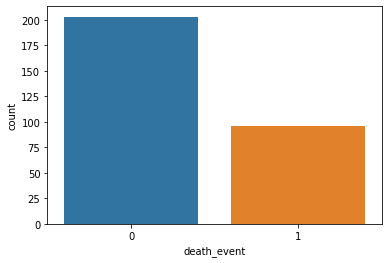

In [8]:
#sns.countplot('death_event', data=data)
sns.countplot(x=data['death_event'])

Зафиксированых случаев смерти почти в два раза меньше чем случев с положительным исходом, таким образом имеется явный дисбаланс классов.

Посмотри еще раз на описание данных с целью понимания разброса значений признаков.

In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,299.0,60.829431,11.894997,40.0,51.0,60.0,70.0,95.0
anaemia,299.0,0.431438,0.496107,0.0,0.0,0.0,1.0,1.0
creatinine_phosphokinase,299.0,581.839465,970.287881,23.0,116.5,250.0,582.0,7861.0
diabetes,299.0,0.418060,0.494067,0.0,0.0,0.0,1.0,1.0
ejection_fraction,299.0,38.083612,11.834841,14.0,30.0,38.0,45.0,80.0
high_blood_pressure,299.0,0.351171,0.478136,0.0,0.0,0.0,1.0,1.0
platelets,299.0,263358.029264,97804.236869,25100.0,212500.0,262000.0,303500.0,850000.0
serum_creatinine,299.0,1.393880,1.034510,0.5,0.9,1.1,1.4,9.4
serum_sodium,299.0,136.625418,4.412477,113.0,134.0,137.0,140.0,148.0
sex,299.0,0.648829,0.478136,0.0,0.0,1.0,1.0,1.0


Итак, почти все признаки, кроме `creatinine_phosphokinase` и `serum_creatinine`, показывают нормальное распределение, поскольку их медиана и среднее значение(второй квартиль) почти совпадают. Для визуализации распределений воспользуемся функцией displot().

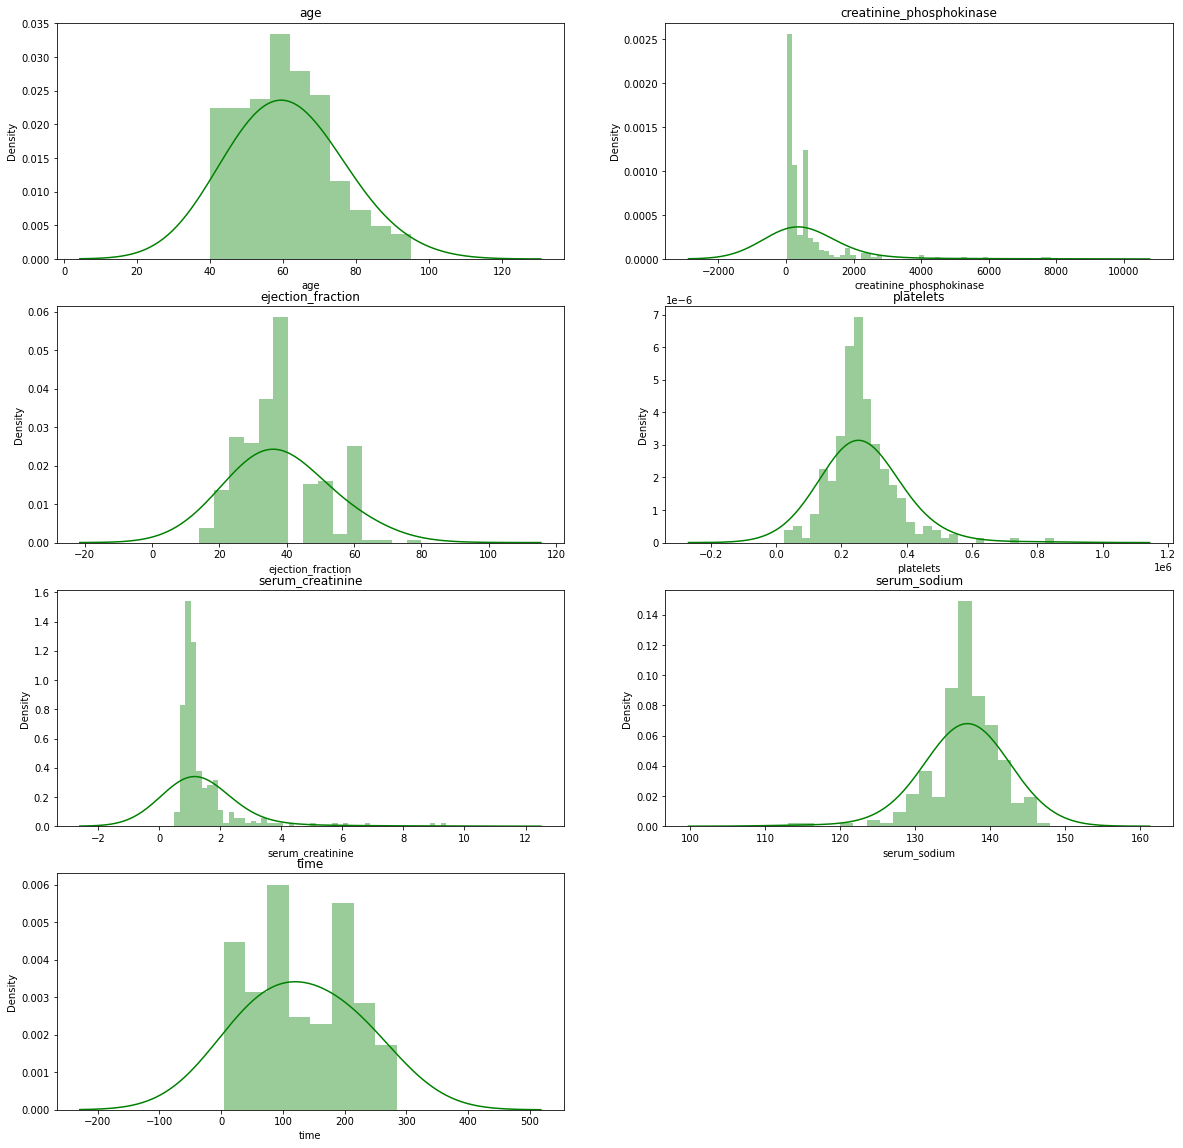

In [10]:
list_of_numerical_features = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']

fig, ax = plt.subplots(nrows = 3,ncols = 2,figsize = (20,20))
for i in range(len(list_of_numerical_features)):
    plt.subplot(4,2,i+1)
    sns.distplot(data[list_of_numerical_features[i]],color = 'g', kde_kws = {'bw' : True});
    title = list_of_numerical_features[i]
    plt.title(title)

In [11]:
#list_of_categorical_features = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 'death_event']

#fig, ax = plt.subplots(nrows = 3,ncols = 2,figsize = (15,15))
#for i in range(len(list_of_categorical_features)):
    #plt.subplot(3,2,i+1)
    #sns.distplot(data[list_of_categorical_features[i]],color = 'g', kde_kws = {'bw' : True});
    #title = list_of_categorical_features[i]
    #plt.title(title)

Используя тепловую карту, посмотрим на корреляцию величин.

<AxesSubplot:>

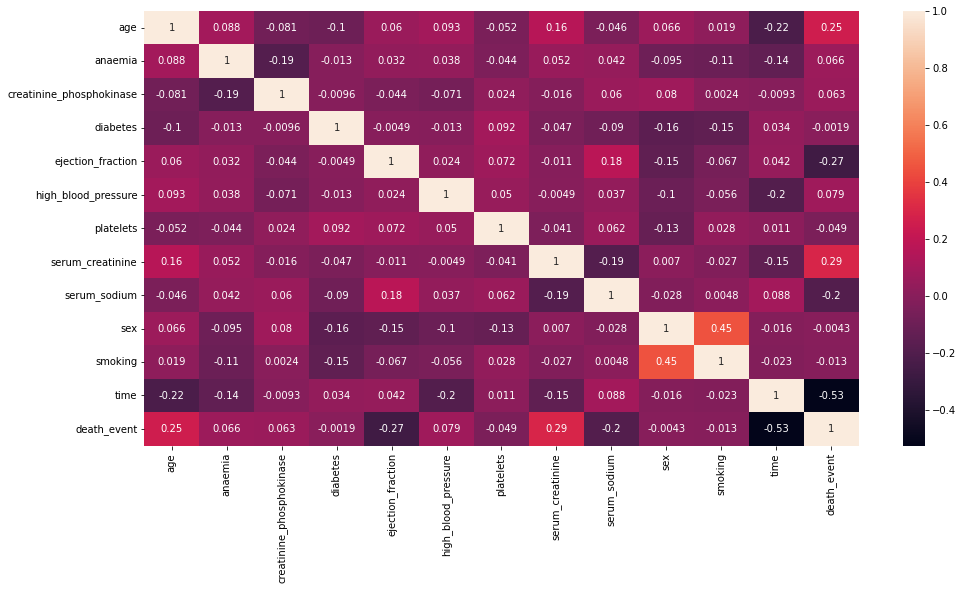

In [12]:
correlation_matrix = data.corr()

plt.figure(figsize= (16, 8))
sns.heatmap(correlation_matrix, annot = True)

Видим, что положительная корреляция есть между полом и курением. Отрицательная корреляция наблюдается между временем наблюдения и целевым признаком. Несильная связь есть между целевым признаком и возрастом, уровнем креатинина и натрия (разнонаправленные) и размером выброса крови при сокращении сердца. 

С помощью boxplot() удобно проверить наличие выбросов(для небинарных признаков), swarmplot() наглядно продемонстрирует распределение значений признаков, а так же их взаимосвязь с целевым признаком.

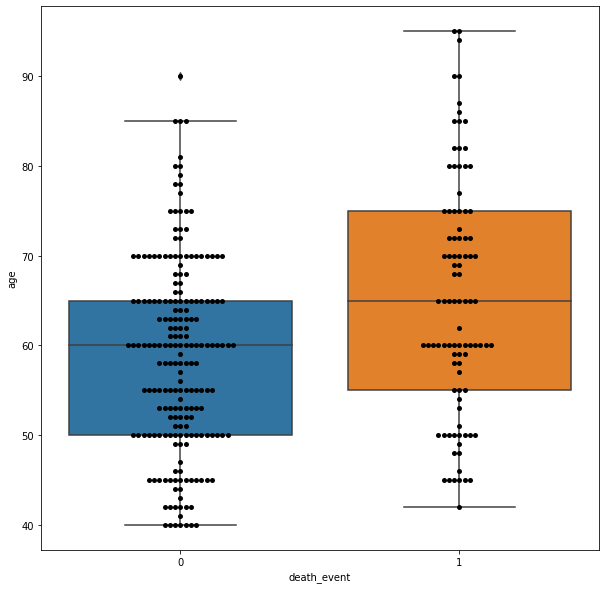

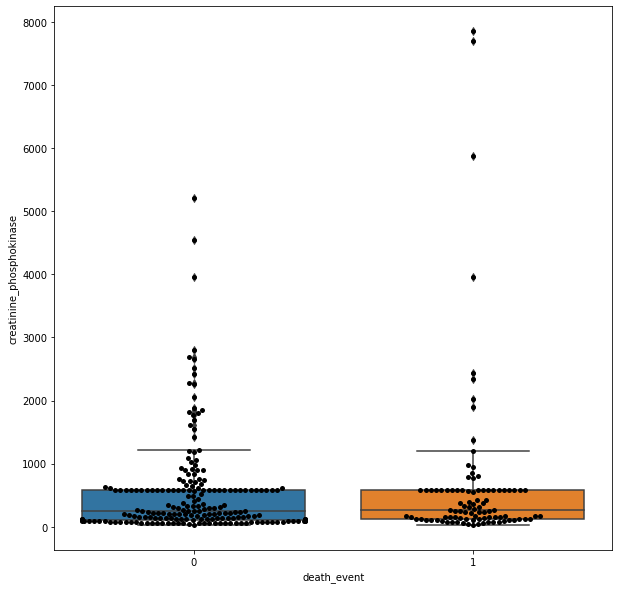

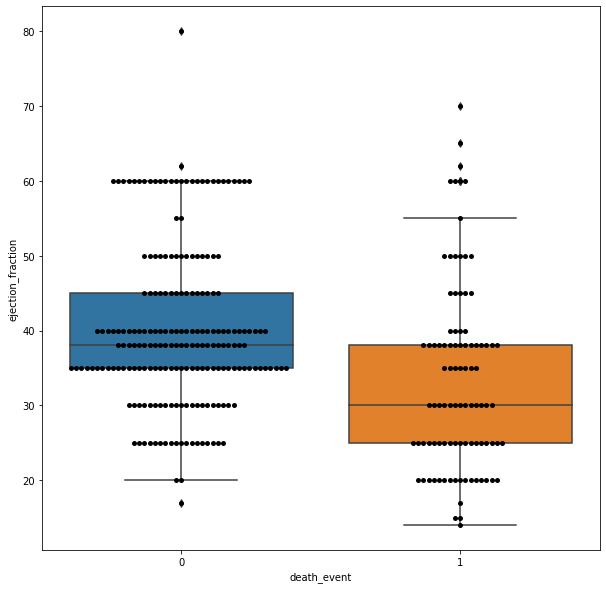

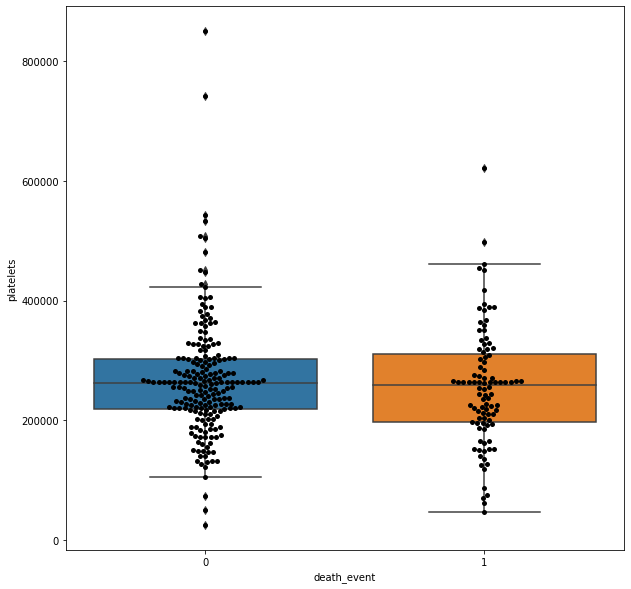

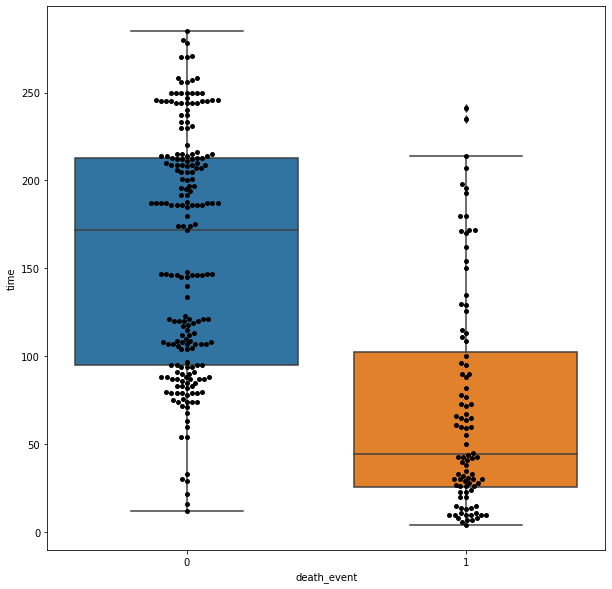

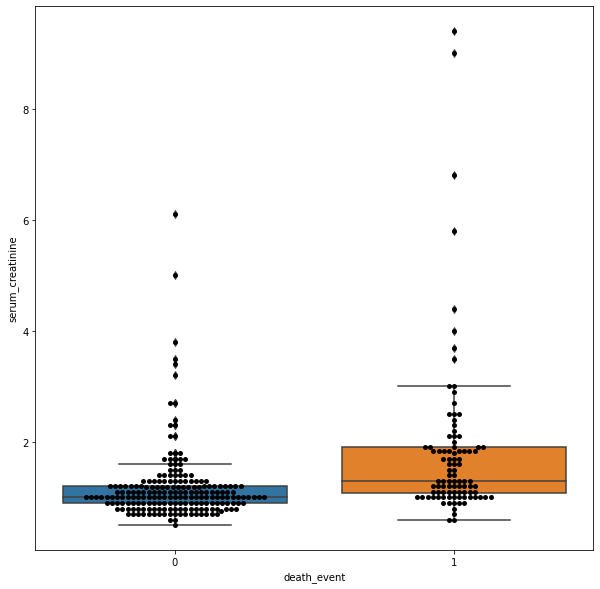

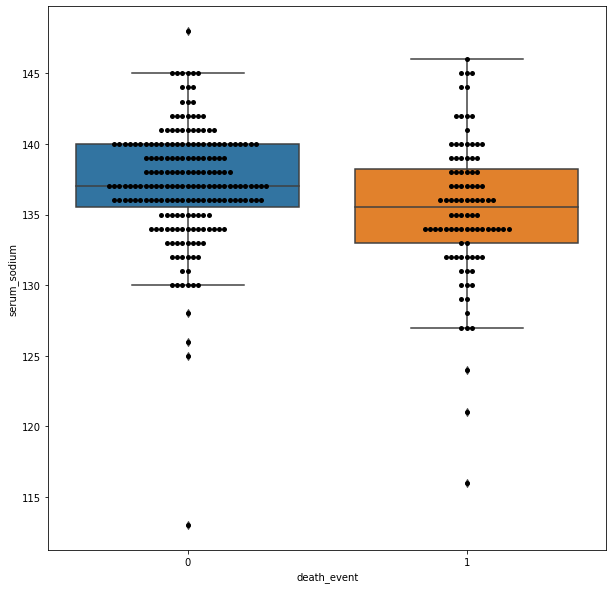

In [13]:
feature_for_boxplot = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets','time','serum_creatinine', 'serum_sodium']
for i in range(len(feature_for_boxplot)):
    plt.figure(figsize=(10,10))
    #sns.stripplot(y=data[feature_for_boxplot[i]], x=data['death_event'], color='black')
    sns.swarmplot(y=data[feature_for_boxplot[i]], x=data['death_event'], color='black')
    sns.boxplot(y=data[feature_for_boxplot[i]], x=data['death_event'])
    plt.show


Почти во всех признаках наблюдаются выбросы. Учитывая размер и релевантость выборки, выбросы удалять не будем.
Выводы: чем страше возраст, тем больше  смертей фиксируется, то есть прослеживается положительная корреляция. По мере уменьшения `ejection_fraction`  люди умирают больше, для `serum_sodium` аналогично. Для `creatinine_phosphokinase` медианы слева накладываются друг на друга - выводы относительно этого признака сделать нельзя на данном этапе, возможно, что имеется более сложная взаимосвязь между величиной этого параметра и смертностью, нечто похожее наблюдается и в случае признака `platelets` . При повышении `serum_creatinine`  наблюдается повышени смертности, то есть мы видим положительную корреляцию. Относительно времени можно заключить следующее: чем меньше время наблюдения, тем выше вероятность летального исхода, иными словами, чем больше человек под наблюдением, тем выше шанс выживания.

Проанализируем, как зависит целевой признак от наличия того или иного признака (бинарного).

,number_of_death,number_of_observations,mortality_rate
anaemia,,,
0,50,170,0.294118
1,46,129,0.356589


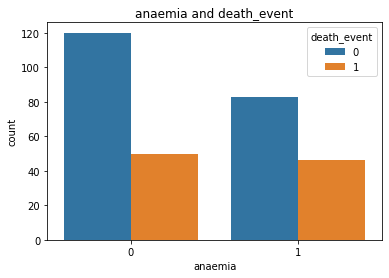

,number_of_death,number_of_observations,mortality_rate
diabetes,,,
0,56,174,0.321839
1,40,125,0.320000


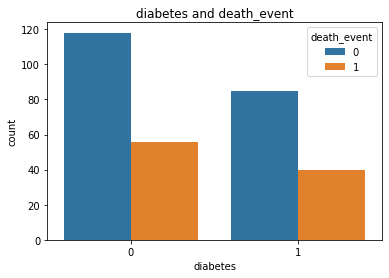

,number_of_death,number_of_observations,mortality_rate
high_blood_pressure,,,
0,57,194,0.293814
1,39,105,0.371429


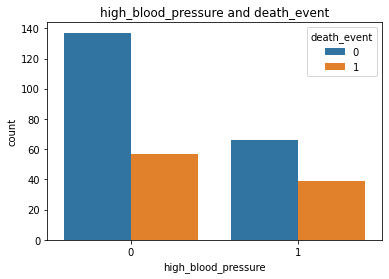

,number_of_death,number_of_observations,mortality_rate
sex,,,
0,34,105,0.323810
1,62,194,0.319588


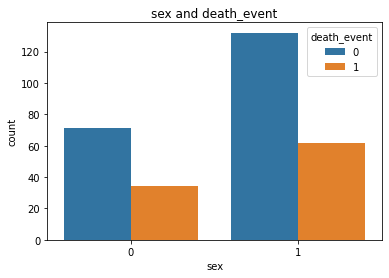

,number_of_death,number_of_observations,mortality_rate
smoking,,,
0,66,203,0.325123
1,30,96,0.312500


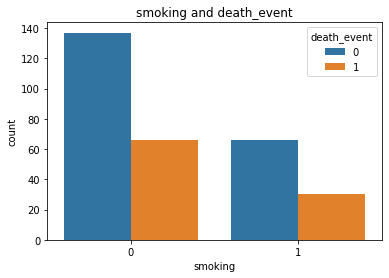

In [14]:
list_of_categorical_features = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 'death_event']
for i in range(len(list_of_categorical_features)-1):
    table = data.pivot_table(index=list_of_categorical_features[i], values='death_event', aggfunc=['sum','count'])
    table.columns = ['number_of_death','number_of_observations']
    table['mortality_rate'] = table['number_of_death']/table['number_of_observations']
    display(table)
    sns.countplot(x = data[list_of_categorical_features[i]],data=data, hue='death_event');
    title = list_of_categorical_features[i] + ' and death_event' 
    plt.title(title)
    plt.show()


Согласно графикам и расчетам в таблицах можно отметить следующее: риски смертности увеличивается при наличии анемии и высокого давления, диабет, курение и пол не повышают риски.

Но, очень важно отметить, что имеется явный дисбаланс в данных, на последнем примере это очень хорошо видно, подгруппа курящих пациентов более чем в два раза меньше подгруппы некурящих, это затрудняет сделать правильный вывод относительно смертности по данному признаку. Это распространяется и на другие группы.

Поэтому, основываясь на данных, которые у нас имеются, мы не можем с уверенностью считать, что наши выводы до конца корректны. 

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,death_event
0,75,582,20,265000.00,1.9,130,1
1,55,7861,38,263358.03,1.1,136,1
2,65,146,20,162000.00,1.3,129,1
3,50,111,20,210000.00,1.9,137,1
4,65,160,20,327000.00,2.7,116,1
...,...,...,...,...,...,...,...
294,62,61,38,155000.00,1.1,143,0
295,55,1820,38,270000.00,1.2,139,0
296,45,2060,60,742000.00,0.8,138,0
297,45,2413,38,140000.00,1.4,140,0


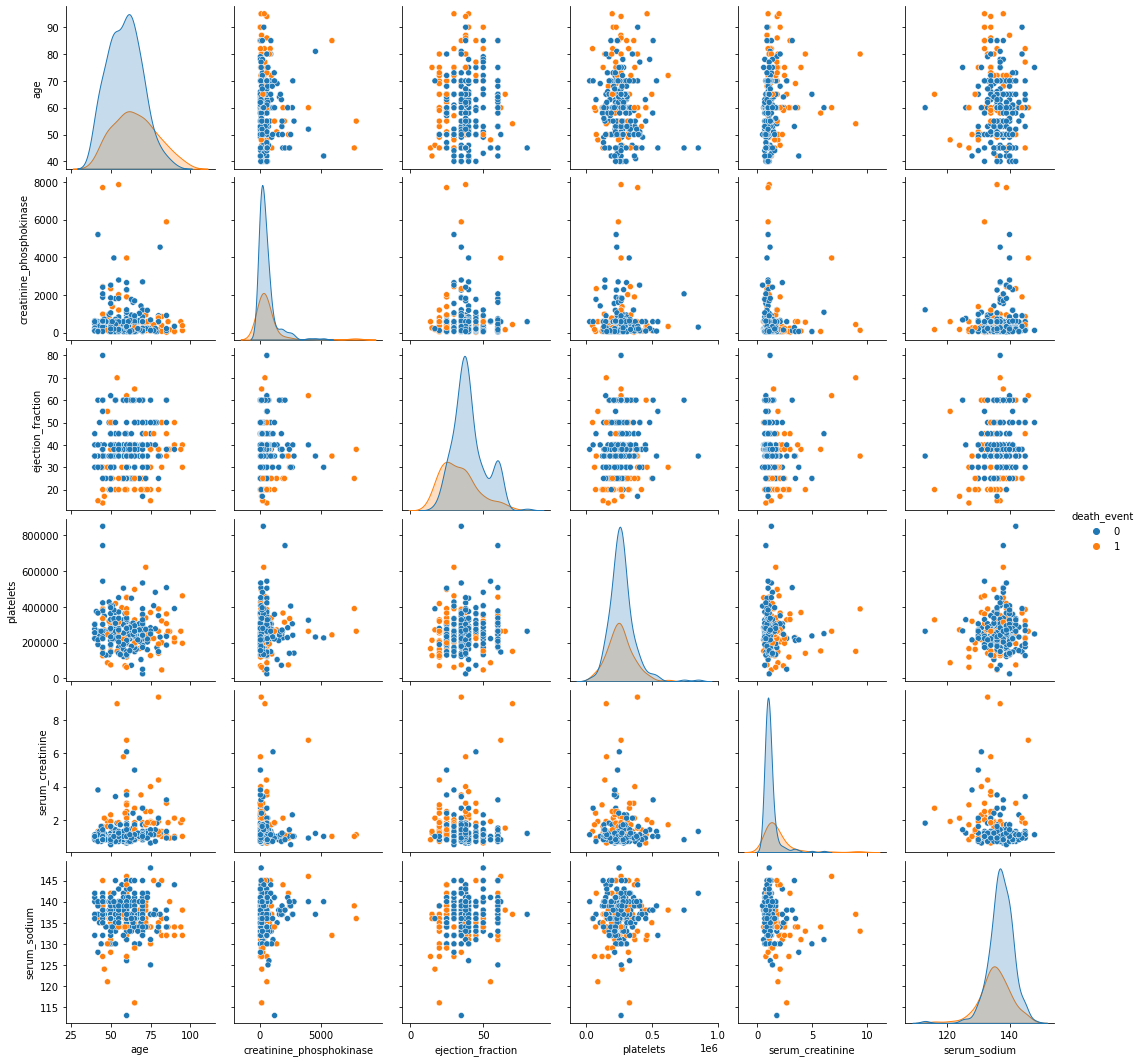

In [15]:
list_drop = list_of_categorical_features + ['time'] 
list_drop.remove('death_event')
data_numerical = data.drop(list_drop, axis=1)
display(data_numerical)
sns.pairplot(data_numerical, hue='death_event')

Видим, что данные кучкуются в некоторых параметрах (хорошо видно на времени наблюдения, как на первых неделях высока смертность, на объёме сердцебиения можно заметить). По диагональным распределениям можно сказать, что чем сильнее различаются кривые, тем заметней влияние величин друг на друга. Скорее всего, влияние параметра, связанного с тромбоцитами, будет несущественное. Оранжевая кривая полностью скрывается под синей, симметрично и с максимумом на одной оси (визуально).

### Моделирование

 В переменных features_train, target_train и features_test,target_test сохраним данные для тренировки и теста, соответственно. 

In [16]:
features = data.drop(['death_event'], axis=1) # признаки
target = data['death_event'] # целевые признаки

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.2, random_state = 12345, stratify=target)


В качестве метрики используем f1-score, чтобы балансировать ошибки первого и второго рода. 

In [17]:
rating_list = {
    'f1-score': [],
    'recall-score': [],
    'precision-score': []
}

In [18]:
def print_scores(model, features, target):
    score_f1 = cross_val_score(model, features, target, scoring="f1", cv=5)
    score_recall = cross_val_score(model, features, target, scoring="recall", cv=5)
    score_precision = cross_val_score(model, features, target, scoring="precision", cv=5)

    print('Диапазон значений метрик:')
    print('f1-score:', score_f1)
    print("recall-score:", score_recall)
    print("precision-score:", score_precision)
    print('\nСредние значения метрик:')
    print('f1-score:', score_f1.mean())
    print("recall-score:", score_recall.mean())
    print("precision-score:", score_precision.mean())
    #print(sum(score_recall)/len(score_recall))
    
    
    rating_list['f1-score'].append(score_f1.mean())
    rating_list['recall-score'].append(score_recall.mean())
    rating_list['precision-score'].append(score_precision.mean())
    
   

In [19]:
# случайный лес
model_forest = RandomForestClassifier(random_state=RANDOM_STATE)
model_forest.fit(features_train, target_train)
# predicted = model.predict(features_test)
# print('f1-score:', f1_score(target_test, predicted))
# print("roc-auc-score:" , roc_auc_score(target_test, predicted))

print_scores(model_forest, features_train, target_train)


Диапазон значений метрик:
f1-score: [0.8        0.68965517 0.64       0.86666667 0.66666667]
recall-score: [0.8        0.66666667 0.5        0.8125     0.73333333]
precision-score: [0.8        0.71428571 0.88888889 0.92857143 0.61111111]

Средние значения метрик:
f1-score: 0.7325977011494252
recall-score: 0.7025
precision-score: 0.7885714285714285


In [20]:
# логистическая регрессия
model_log = LogisticRegression(random_state=RANDOM_STATE)
model_log.fit(features_train, target_train)

print_scores(model_log, features_train, target_train)



Диапазон значений метрик:
f1-score: [0.72       0.62068966 0.53846154 0.73333333 0.59259259]
recall-score: [0.6        0.6        0.4375     0.6875     0.53333333]
precision-score: [0.9        0.64285714 0.7        0.78571429 0.66666667]

Средние значения метрик:
f1-score: 0.6410154239119756
recall-score: 0.5716666666666667
precision-score: 0.739047619047619


In [21]:
# CatBoostClassifier
model_cat = CatBoostClassifier(random_state=RANDOM_STATE, silent=True)
model_cat.fit(features_train, target_train)

print_scores(model_cat, features_train, target_train)


Диапазон значений метрик:
f1-score: [0.74074074 0.71428571 0.52173913 0.83870968 0.75      ]
recall-score: [0.66666667 0.66666667 0.375      0.8125     0.8       ]
precision-score: [0.83333333 0.76923077 0.85714286 0.86666667 0.70588235]

Средние значения метрик:
f1-score: 0.7130950525761184
recall-score: 0.6641666666666666
precision-score: 0.8064511958629605


In [22]:
rating_table = {
    'Model': ['RandomForestClassifier', 'LogisticRegression', 'CatBoostClassifier'],
    'f1-score': rating_list['f1-score'],
    'recall-score': rating_list['recall-score'],
    'precision-score': rating_list['precision-score']
}
rating_table = pd.DataFrame(rating_table)
rating_table.sort_values('f1-score', ascending=False).style.highlight_max(subset=['f1-score', 'recall-score', 'precision-score'])

,Model,f1-score,recall-score,precision-score
0,RandomForestClassifier,0.732598,0.702500,0.788571
2,CatBoostClassifier,0.713095,0.664167,0.806451
1,LogisticRegression,0.641015,0.571667,0.739048


Таким образом, случайный лес имеет лучшие оценки на валидационных данных по метрике f1.
При этом положительный класс лучше определяет CatBoost, а ложноотрицательных предсказаний меньше снова у случайного леса.

### Подбор параметров
Подберём параметры для каждой модели. Критерием будет метрика f1.

In [23]:
# баланс классов
#target_train.value_counts(normalize=True)

In [24]:
scaler = StandardScaler()
scaler.fit(features_train) 
features_train_scaled = scaler.transform(features_train)

In [25]:
rating_list = {
    'f1-score': [],
    'recall-score': [],
    'precision-score': []
}

#### случайный лес

In [26]:
parameters = {'n_estimators' : range (1, 100, 2), 
              'max_depth' : range (1, 20, 2), 
              'bootstrap' : ('True', 'False'),
              'class_weight':('balanced', 'None','balanced_subsample', [0.30, 0.70], [0.70, 0.30])
             }

grid_forest = GridSearchCV(RandomForestClassifier(random_state=RANDOM_STATE), parameters,\
                           scoring='f1', cv = 5, n_jobs= -1)   # , class_weight = 'balanced'
grid_forest.fit(features_train_scaled, target_train)

grid_forest.best_params_

{'bootstrap': 'True',
 'class_weight': 'balanced_subsample',
 'max_depth': 5,
 'n_estimators': 13}

In [27]:
model_forest = RandomForestClassifier(n_estimators=grid_forest.best_params_.get('n_estimators'),\
                                      max_depth=grid_forest.best_params_.get('max_depth'),\
                                      bootstrap=grid_forest.best_params_.get('bootstrap'),\
                                      random_state=RANDOM_STATE, class_weight=grid_forest.best_params_.get('class_weight'))



In [28]:
print('f1-score:', grid_forest.best_score_)

f1-score: 0.7932208967503085


In [29]:
score_recall = cross_val_score(model_forest, features_train_scaled, target_train, scoring="recall", cv=5)
score_precision = cross_val_score(model_forest, features_train_scaled, target_train, scoring="precision", cv=5)
rating_list['f1-score'].append(grid_forest.best_score_)
rating_list['recall-score'].append(score_recall.mean())
rating_list['precision-score'].append(score_precision.mean())

#### логистическая регрессия

In [30]:
parameters = {'solver':('liblinear', 'newton-cg', 'sag', 'saga', 'lbfgs'), 
              'max_iter': range(1,120, 10),
              'class_weight':('balanced', 'None', [0.30, 0.70], [0.70, 0.30])
             }  

grid_log = GridSearchCV(LogisticRegression(random_state=RANDOM_STATE), parameters, scoring="f1",\
                        cv = 5)
grid_log.fit(features_train_scaled, target_train)

grid_log.best_params_

{'class_weight': 'balanced', 'max_iter': 11, 'solver': 'liblinear'}

In [31]:
model_log = LogisticRegression(solver=grid_log.best_params_.get('solver'),\
                               max_iter=grid_log.best_params_.get('max_iter'),\
                               class_weight=grid_log.best_params_.get('class_weight'), random_state=RANDOM_STATE)


In [32]:
print('f1-score:', grid_log.best_score_)

f1-score: 0.709037783770972


In [33]:
score_recall = cross_val_score(model_log, features_train_scaled, target_train, scoring="recall", cv=5)
score_precision = cross_val_score(model_log, features_train_scaled, target_train, scoring="precision", cv=5)
rating_list['f1-score'].append(grid_log.best_score_)
rating_list['recall-score'].append(score_recall.mean())
rating_list['precision-score'].append(score_precision.mean())

#### CatBoost

In [34]:
parameters_cat = {'l2_leaf_reg': range (1, 15, 2), 
                  'iterations' : range(1, 100, 10),
                  'learning_rate':[0.03, 0.07, 0.1, 0.13, 0.17],
                  'max_depth' : range(1, 10, 2),
                 }

grid_cat = GridSearchCV(CatBoostClassifier(random_state=RANDOM_STATE),\
                        parameters_cat, scoring="f1",  cv = 5, n_jobs= -1)
grid_cat.fit(features_train_scaled, target_train, silent=True)
grid_cat.best_params_

{'iterations': 81, 'l2_leaf_reg': 1, 'learning_rate': 0.13, 'max_depth': 5}

In [35]:
model_cat = CatBoostClassifier(l2_leaf_reg=grid_cat.best_params_.get('l2_leaf_reg'),\
                               iterations=grid_cat.best_params_.get('iterations'),\
                               learning_rate=grid_cat.best_params_.get('learning_rate'),\
                               max_depth=grid_cat.best_params_.get('max_depth'),\
                               random_state=RANDOM_STATE, silent=True)

In [36]:
print('f1-score:', grid_cat.best_score_)

f1-score: 0.7737189469781238


In [37]:
score_recall = cross_val_score(model_cat, features_train_scaled, target_train, scoring="recall", cv=5)
score_precision = cross_val_score(model_cat, features_train_scaled, target_train, scoring="precision", cv=5)
rating_list['f1-score'].append(grid_cat.best_score_)
rating_list['recall-score'].append(score_recall.mean())
rating_list['precision-score'].append(score_precision.mean())

In [38]:
rating_table = {
    'Model': ['RandomForestClassifier', 'LogisticRegression', 'CatBoostClassifier'],
    'f1-score': rating_list['f1-score'],
    'recall-score': rating_list['recall-score'],
    'precision-score': rating_list['precision-score']
}
rating_table = pd.DataFrame(rating_table)
rating_table.sort_values('f1-score', ascending=False).style.highlight_max(subset=['f1-score',\
                                                 'recall-score', 'precision-score'])

,Model,f1-score,recall-score,precision-score
0,RandomForestClassifier,0.793221,0.793333,0.813313
2,CatBoostClassifier,0.773719,0.741667,0.816017
1,LogisticRegression,0.709038,0.781667,0.662653


После масштабирования признаков и подбора параметров ситуация не изменилась - случайный лес по-прежнему имеет лучшие оценки по метрикам f1 и recall. CatBoost лучше определяет положительный класс.

### Тестирование

Выберем одну модель - случайный лес и протестируем ее.

In [39]:
scaler = StandardScaler()
scaler.fit(features_test) 
features_test_scaled = scaler.transform(features_test)

best_model= model_forest.fit(features_train_scaled, target_train)
predictions = best_model.predict(features_test_scaled)

print('f1-score:', f1_score(target_test, predictions))
print('recall-score:', recall_score(target_test, predictions))
print("precision-score:" , precision_score(target_test, predictions))

f1-score: 0.7567567567567567
recall-score: 0.7368421052631579
precision-score: 0.7777777777777778


<AxesSubplot:>

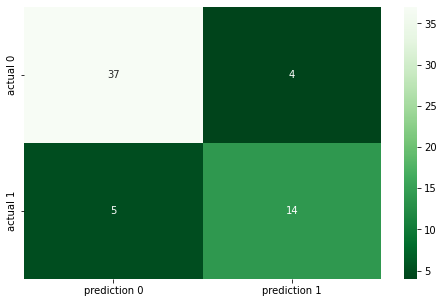

In [40]:
conf_matrix = confusion_matrix(target_test, predictions)
table_conf_matrix = pd.DataFrame(data=conf_matrix, columns=['prediction 0','prediction 1'],\
                                 index=['actual 0','actual 1'])
#labels = ['True Neg','False Pos','False Neg','True Pos']
#labels = np.asarray(labels).rashape(2,2)
plt.figure(figsize = (8,5))
sns.heatmap(table_conf_matrix, annot=True, cmap='Greens_r')

Оценка точности на тестовой выборке по метрике f1 для модели случайного леса равна 0.757.

#### feature importances

Посмотрим, какие из исходных параметров оказали большее влияние на предсказания.

Text(0.5, 1.0, 'Correlation Heatmap\n')

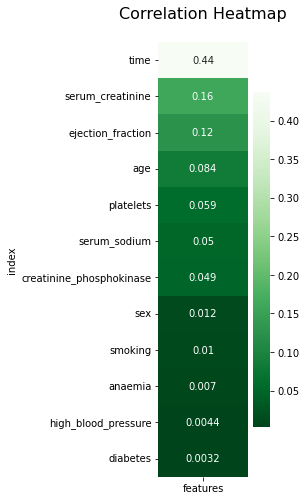

In [41]:
feature_names = features_train.columns
forest_importances = pd.Series(model_forest.feature_importances_, index=feature_names).reset_index()
forest_importances.index=forest_importances['index']
forest_importances.rename(columns={0:'features'}, inplace=True)
plt.figure(figsize=(2,8))
sns.heatmap(forest_importances[['features']].sort_values(by='features',ascending=False),\
            annot=True, cmap='Greens_r')
plt.title('Correlation Heatmap'+'\n',fontsize=16)

Три параметра, которые имеют большее влияние на выбор класса - время наблюдения за пачиентом, уровень креатинина и объём крови, выталкиваемый сердцем за одно сокращение. Пол, курение, анемия, высокое давление и тем более диабет у пациента - как будто лишние элементы в этом исследовании.

Это выглядит подозрительно, потому что мы знаем, что эти параметры сегодня считаются факторами риска при ССЗ.

### Выводы

Для задачи предсказания смерти от сердечно-сосудистых заболеваний (ССЗ) мы рассмотрели три модели - случайный лес, линейную регрессию и CatBoost. Метрикой качества выбрали f1 из-за сильного дисбаланса классов. Поскольку важно было понимать, сколько пациентов, нуждающихся во внимании врачей, не получат его, мы решили в том числе присматриваться к метрике recall.

На предобработке данных не было обнаружено пропусков, дублей а также взаимозависимотей в исходных данных. Почти во всех признаках наблюдаются выбросы, но из-за небольшого объёма выборки мы не стали их удалять. Стоит поднять вопрос о релевантности данных. По многим параметрам наблюдается дисбаланс (курящих в 2+ раза больше некурящих).

##### Моделирование.

Лучшей базовой моделью стал случайный лес (f1=0.73).
При подборе параметров удалось повысить метрику до f1=0.79.
Тестирование показало небольшое падение f1 до 0,76.


Оценка влияния различных параметров здоровья на предсказания модели показала, что самым влиятельным является время наблюдения за пациентом, а самыми незначительными - пол, курение, наличие анемии, диабета или высокого давления. Между тем, именно последние у всех на слуху.

##### Рекомендации

Для дальнейшей работы предлагается смоделировать предсказания без параметра `time` и обратиться к заказчику за увеличением исходного объёма данных.